In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# here we doing is importing the libraries required and also the dataset reading
df_purchase = pd.read_csv("User_product_purchase_details_p2.csv")
df_user = pd.read_csv("user_demographics.csv")



In [26]:
print(f"\nPurchase Data Shape: {df_purchase.shape}, and User Demographics Shape: {df_user.shape}")
print(f"Purchase Data Columns: {df_purchase.columns.tolist()}")
print(f"User Demographics Columns: {df_user.columns.tolist()}")

#these are inintal readings



Purchase Data Shape: (550068, 9), and User Demographics Shape: (5891, 4)
Purchase Data Columns: ['User_ID', 'Product_ID', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase']
User Demographics Columns: ['User_ID', 'Gender', 'Age', 'Occupation']


In [27]:
# merging based on the key and here the key is User_ID
df = pd.merge(df_purchase, df_user, on="User_ID", how="left")
print(f"\nMerged Data Shape: {df.shape}")

# Create binary target variable
df["High_Value_Purchase"] = (df["Purchase"] >= 10000).astype(int)

print(f"\nTarget Distribution:")
print(df["High_Value_Purchase"].value_counts())
print(f"High-Value Purchase Ratio: {df['High_Value_Purchase'].mean():.2%}")

# Drop unnecessary columns
# these are not related and dont play any significance role so remove or drop it.
df = df.drop(["Product_ID", "User_ID"], axis=1)

# Check missing values
print(f"\nMissing Values:\n")
print(df.isnull().sum())


Merged Data Shape: (550068, 12)

Target Distribution:
High_Value_Purchase
0    360529
1    189539
Name: count, dtype: int64
High-Value Purchase Ratio: 34.46%

Missing Values:

City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
Gender                             0
Age                                0
Occupation                         0
High_Value_Purchase                0
dtype: int64


In [28]:
# Handle missing values : set NaN to 0
df = df.fillna(0)

# Encode categorical variables
print("ENCODING CATEGORICAL VARIABLES")

# Label encode categorical columns
categorical_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
label_encoders = {}

for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"{col}: {len(le.classes_)} unique values")


ENCODING CATEGORICAL VARIABLES
Gender: 2 unique values
Age: 7 unique values
City_Category: 3 unique values
Stay_In_Current_City_Years: 5 unique values


In [29]:
# Separate features and target
X = df.drop(["High_Value_Purchase", "Purchase"], axis=1)
y = df["High_Value_Purchase"]

print(f"\nFinal Feature Set Shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")


Final Feature Set Shape: (550068, 9)
Features: ['City_Category', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Gender', 'Age', 'Occupation']

Train Set Size: 440054
Test Set Size: 110014


In [30]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
#BASELINE MODEL: LOGISTIC REGRESSION

print("LOGISTIC REGRESSION MODEL")

log_model = LogisticRegression(max_iter=2000, random_state=42)
log_model.fit(X_train_scaled, y_train)


LOGISTIC REGRESSION MODEL


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [32]:
# Predictions
pred_lr = log_model.predict(X_test_scaled)


In [33]:
# Evaluation
lr_accuracy = accuracy_score(y_test, pred_lr)
print(f"\n✓ Logistic Regression Accuracy: {lr_accuracy:.4f}")



✓ Logistic Regression Accuracy: 0.7670


In [34]:
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, pred_lr)
print(cm_lr)



Confusion Matrix:
[[64646  7694]
 [17939 19735]]


In [35]:
print("\nClassification Report:")
print(classification_report(y_test, pred_lr, target_names=['Low Value', 'High Value']))



Classification Report:
              precision    recall  f1-score   support

   Low Value       0.78      0.89      0.83     72340
  High Value       0.72      0.52      0.61     37674

    accuracy                           0.77    110014
   macro avg       0.75      0.71      0.72    110014
weighted avg       0.76      0.77      0.76    110014



In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("\nTop 5 => (Positive Impact):")
print(feature_importance.head())
print("\nTop 5 => (Negative Impact):")
print(feature_importance.tail())



Top 5 Most Influential Features (Positive Impact):
              Feature  Coefficient
5  Product_Category_3     0.427128
6              Gender     0.110713
0       City_Category     0.085917
7                 Age     0.037943
4  Product_Category_2     0.027806

Top 5 Most Influential Features (Negative Impact):
                      Feature  Coefficient
4          Product_Category_2     0.027806
8                  Occupation     0.021584
1  Stay_In_Current_City_Years     0.002006
2              Marital_Status    -0.004365
3          Product_Category_1    -0.853088


In [ ]:
# NEURAL NETWORK: MLP CLASSIFIER

print("MLP MODEL")

# Build MLP model
mlp_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
mlp_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


MLP (MULTI-LAYER PERCEPTRON) MODEL


c:\Users\User\Downloads\azure_openai_lab_pack_final\env_variable\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
print("\nModel Architecture:")
mlp_model.summary()



Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nTraining MLP Model")
history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)



Training MLP Model...
Epoch 1/20


11002/11002 ━━━━━━━━━━━━━━━━━━━━ 12s 996us/step - accuracy: 0.8302 - loss: 0.4070 - val_accuracy: 0.8695 - val_loss: 0.3186
Epoch 2/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 11s 985us/step - accuracy: 0.8761 - loss: 0.3131 - val_accuracy: 0.8897 - val_loss: 0.2853
Epoch 3/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 10s 950us/step - accuracy: 0.8841 - loss: 0.2946 - val_accuracy: 0.8900 - val_loss: 0.2741
Epoch 4/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.8858 - loss: 0.2873 - val_accuracy: 0.8903 - val_loss: 0.2669
Epoch 5/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8873 - loss: 0.2845 - val_accuracy: 0.8915 - val_loss: 0.2658
Epoch 6/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8890 - loss: 0.2809 - val_accuracy: 0.8934 - val_loss: 0.2632
Epoch 7/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 20s 986us/step - accuracy: 0.8901 - loss: 0.2793 - val_accuracy: 0.8969 - val_loss: 0.2599
Epoch 8/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 10s 944us/step - accuracy: 0

In [40]:
# Evaluate on test set
loss, mlp_accuracy = mlp_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\n MLP Test Accuracy: {mlp_accuracy:.4f}")
print(f"MLP Test Loss: {loss:.4f}")



 MLP Test Accuracy: 0.8958
MLP Test Loss: 0.2605


In [41]:
# MLP Predictions
pred_mlp = (mlp_model.predict(X_test_scaled) > 0.5).astype(int).flatten()

print("\nConfusion Matrix:")
cm_mlp = confusion_matrix(y_test, pred_mlp)
print(cm_mlp)


3438/3438 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step

Confusion Matrix:
[[62277 10063]
 [ 1405 36269]]


In [42]:
print("\nClassification Report:")
print(classification_report(y_test, pred_mlp, target_names=['Low Value', 'High Value']))



Classification Report:
              precision    recall  f1-score   support

   Low Value       0.98      0.86      0.92     72340
  High Value       0.78      0.96      0.86     37674

    accuracy                           0.90    110014
   macro avg       0.88      0.91      0.89    110014
weighted avg       0.91      0.90      0.90    110014



In [43]:
# MODEL COMPARISON

print("MODEL COMPARISON & ANALYSIS")

comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'MLP Neural Network'],
    'Accuracy': [lr_accuracy, mlp_accuracy],
    'Difference': [0, mlp_accuracy - lr_accuracy]
})

print("\n" + comparison.to_string(index=False))


MODEL COMPARISON & ANALYSIS

              Model  Accuracy  Difference
Logistic Regression  0.767002    0.000000
 MLP Neural Network  0.895759    0.128756


In [44]:
# Performance analysis
print("KEY INSIGHTS")

if mlp_accuracy > lr_accuracy:
    improvement = (mlp_accuracy - lr_accuracy) / lr_accuracy * 100
    print(f"\n MLP outperformed Logistic Regression by {improvement:.2f}%")
    print("\nPossible reasons:")
    print(" 1. MLP can capture non-linear relationships between features")
    print(" 2. Multiple hidden layers allow learning complex patterns and Better handling of feature interactions")
elif lr_accuracy > mlp_accuracy:
    print(f"\n Logistic Regression outperformed MLP by {(lr_accuracy - mlp_accuracy) / mlp_accuracy * 100:.2f}%")
    print("\nPossible reasons:")
    print(" 1.Data relationships are mostly linear and MLP might be overfitting despite regularization")
    print(" 2. Limited training data for neural network")
else:
    print("\nBoth models performed similarly")
    print("\nThis suggests:")
    print("1.Linear relationships dominate the data")
    print("2.Simple model is sufficient for this task")


KEY INSIGHTS

 MLP outperformed Logistic Regression by 16.79%

Possible reasons:
 1. MLP can capture non-linear relationships between features
 2. Multiple hidden layers allow learning complex patterns and Better handling of feature interactions


In [45]:

print("\nBased on Logistic Regression coefficients:")
print(feature_importance.head(5).to_string(index=False))



Based on Logistic Regression coefficients:
           Feature  Coefficient
Product_Category_3     0.427128
            Gender     0.110713
     City_Category     0.085917
               Age     0.037943
Product_Category_2     0.027806



✓ Training history plot saved as 'mlp_training_history.png'


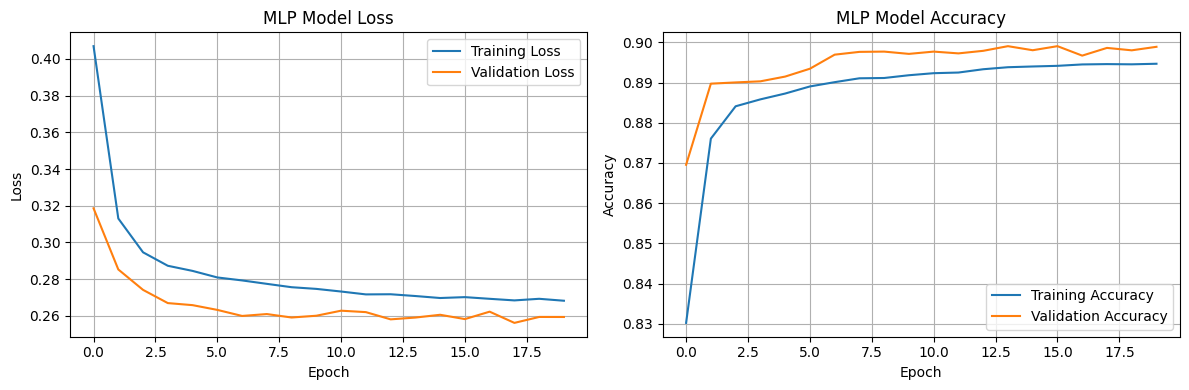

In [46]:
# Visualization: Training History
if len(history.history['loss']) > 1:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MLP Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('MLP Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('mlp_training_history.png', dpi=300, bbox_inches='tight')
    print("\n✓ Training history plot saved as 'mlp_training_history.png'")


Confusion matrices saved as 'confusion_matrices_comparison.png'


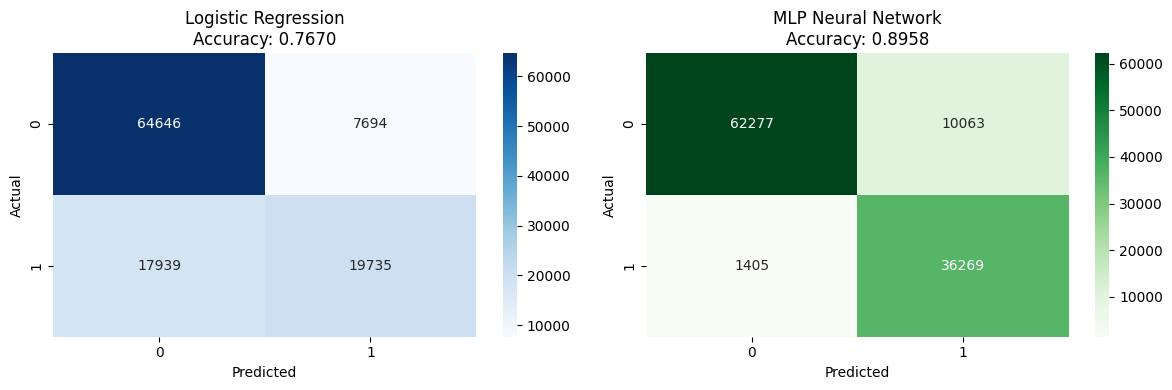

In [47]:
# Confusion Matrix Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Logistic Regression\nAccuracy: {lr_accuracy:.4f}')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'MLP Neural Network\nAccuracy: {mlp_accuracy:.4f}')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
print("Confusion matrices saved as 'confusion_matrices_comparison.png'")